In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import bitfinex
from datetime import datetime
import time



# ML methods
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error


import math
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Activation
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from keras.callbacks import LearningRateScheduler
from keras.metrics import RootMeanSquaredError
from sklearn.linear_model import LinearRegression


In [2]:
api_v1 = bitfinex.bitfinex_v1.api_v1()
pairs = api_v1.symbols()
print(*pairs, sep = ' , ')

No keys, only access to public API functions
btcusd , ltcusd , ltcbtc , ethusd , ethbtc , etcbtc , etcusd , rrtusd , zecusd , zecbtc , xmrusd , xmrbtc , dshusd , dshbtc , btceur , btcjpy , xrpusd , xrpbtc , iotusd , iotbtc , ioteth , eosusd , eosbtc , eoseth , sanusd , omgusd , omgbtc , omgeth , neousd , neobtc , neoeth , etpusd , etpbtc , qtmusd , qtmbtc , edousd , btgusd , btgbtc , datusd , gntusd , sntusd , ioteur , batusd , mnausd , mnabtc , funusd , zrxusd , zrxbtc , zrxeth , trxusd , trxbtc , trxeth , repusd , repbtc , btcgbp , etheur , ethjpy , ethgbp , neoeur , neojpy , neogbp , eoseur , eosjpy , eosgbp , iotjpy , iotgbp , requsd , lrcusd , waxusd , daiusd , daibtc , daieth , bftusd , antusd , antbtc , anteth , stjusd , xlmusd , xlmbtc , xlmeth , xvgusd , mkrusd , kncusd , kncbtc , lymusd , utkusd , veeusd , zcnusd , essusd , iqxusd , zilusd , zilbtc , bntusd , xrausd , vetusd , vetbtc , gotusd , xtzusd , xtzbtc , trxeur , mlnusd , omnusd , pnkusd , pnketh , dgbusd , bsvusd , b

In [3]:
def fetch_data(start=1640991600000, stop=1651356000000, symbol='btcusd', interval='1D', step=86400000):
    # Create api instance
    api_v2 = bitfinex.bitfinex_v2.api_v2()

    # Defining intervals in ms
    intervals_dict = {"1m": 60000, "5m": 300000, "15m": 900000, "30m": 1800000, "1h": 3600000, "3h": 10800000, "6h": 21600000, "12h": 43200000, "1D": 86400000, "7D": 604800000, "14D": 1209600000, "1M": 2628000000}
    step = intervals_dict[interval] * 1000

    
    data = []
    names = ['time', 'open', 'close', 'high', 'low', 'volume']

    if stop > time.time() * 1000: # stop value can't be higher than datetime.now()
        stop = datetime.now()
        stop = time.mktime(stop.timetuple()) * 1000
    if stop - start > step: # if data requested > 1000 * interval
        while start < stop:
            if start + step > stop: # if start + 1000 * interval > stop ==> stop = now
                end = datetime.now()
                end = time.mktime(end.timetuple()) * 1000
            else:
                end = start + step
            #print(datetime.fromtimestamp(start / 1000), datetime.fromtimestamp(end / 1000))
            res = api_v2.candles(symbol=symbol, interval=interval, start=start, end=end)
            data.extend(res)
            start += step
            time.sleep(1)
    else:
        res = api_v2.candles(symbol=symbol, interval=interval, start=start, end=stop)
        data.extend(res)
    #print(data)

    # Modify data to send back a clean DataFrame
    df = pd.DataFrame(data, columns=names)
    df['time'] = pd.to_datetime(df['time'], unit='ms')
    df = df.sort_values(by='time')
    df.reset_index(inplace=True)
    df.drop('index', axis=1, inplace=True)
    df.rename(columns={'time':'date'}, inplace=True)
    return df

In [4]:
pair = 'egld:usd'
interval = '1D'

t_start = datetime(2020, 5, 13, 0, 0)
t_start = time.mktime(t_start.timetuple()) * 1000

t_stop = datetime(2023, 1, 1, 0, 0)
t_stop = time.mktime(t_stop.timetuple()) * 1000

In [5]:
df = fetch_data(start=t_start, stop=t_stop, symbol=pair, interval=interval)
df

No keys, only access to public API functions


,date,open,close,high,low,volume
0,2020-09-10,22.000,14.310,22.000,9.888,16713.541178
1,2020-09-11,14.310,14.321,14.353,14.023,9028.975189
2,2020-09-12,14.324,13.924,14.325,13.803,3973.408883
3,2020-09-13,13.923,13.311,13.979,13.176,3926.393715
4,2020-09-14,13.317,13.981,14.323,13.136,16590.201933
...,...,...,...,...,...,...
619,2022-05-22,91.833,92.201,93.401,90.468,1593.578356
620,2022-05-23,91.824,90.764,94.546,90.177,1738.118232
621,2022-05-24,90.804,90.731,91.735,88.959,2190.726516
622,2022-05-25,90.750,87.437,90.910,86.766,1483.733452


In [6]:
X_scaler = MinMaxScaler(feature_range=(0,1))
y_scaler = MinMaxScaler(feature_range=(0,1))

In [7]:
def SplitData(Data, Date, lstm=0, X_scaler=X_scaler, y_scaler=y_scaler):
  print(Data.index[Data['date'] == Date][0])
  index = Data.index[Data['date'] == Date][0]
  X = Data.drop(columns=['date', 'close'], axis=1).to_numpy()
  y = Data['close'].to_numpy()

  if lstm:
    X = X_scaler.fit_transform(np.array(X))
    y = y_scaler.fit_transform(np.array(y).reshape(-1,1))

    X_train = X[:index]
    y_train = y[:index]
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

    X_test = X[index:]
    y_test = y[index:]
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

  else:
    X_train = X[:index]
    y_train = y[:index]
    X_test = X[index:]
    y_test = y[index:]

  return X_train, y_train, X_test, y_test

# Linear Regression

In [8]:
date = '2022-02-01'
X_train, y_train, X_test, y_test = SplitData(df, date)

509


In [9]:
df

,date,open,close,high,low,volume
0,2020-09-10,22.000,14.310,22.000,9.888,16713.541178
1,2020-09-11,14.310,14.321,14.353,14.023,9028.975189
2,2020-09-12,14.324,13.924,14.325,13.803,3973.408883
3,2020-09-13,13.923,13.311,13.979,13.176,3926.393715
4,2020-09-14,13.317,13.981,14.323,13.136,16590.201933
...,...,...,...,...,...,...
619,2022-05-22,91.833,92.201,93.401,90.468,1593.578356
620,2022-05-23,91.824,90.764,94.546,90.177,1738.118232
621,2022-05-24,90.804,90.731,91.735,88.959,2190.726516
622,2022-05-25,90.750,87.437,90.910,86.766,1483.733452


## Test

In [10]:
linear_regression_model = LinearRegression()
linear_regression_model.fit(X_train, y_train)

LinearRegression()

In [11]:
linear_regression_train_predict=linear_regression_model.predict(X_train)
linear_regression_validation_predict=linear_regression_model.predict(X_test)

print("Train data prediction:", linear_regression_train_predict.shape)
print("Validation data prediction:", linear_regression_validation_predict.shape)
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_test, linear_regression_validation_predict)))

Train data prediction: (509,)
Validation data prediction: (115,)
Mean Absolute Error - MAE : 3.3001979599388136


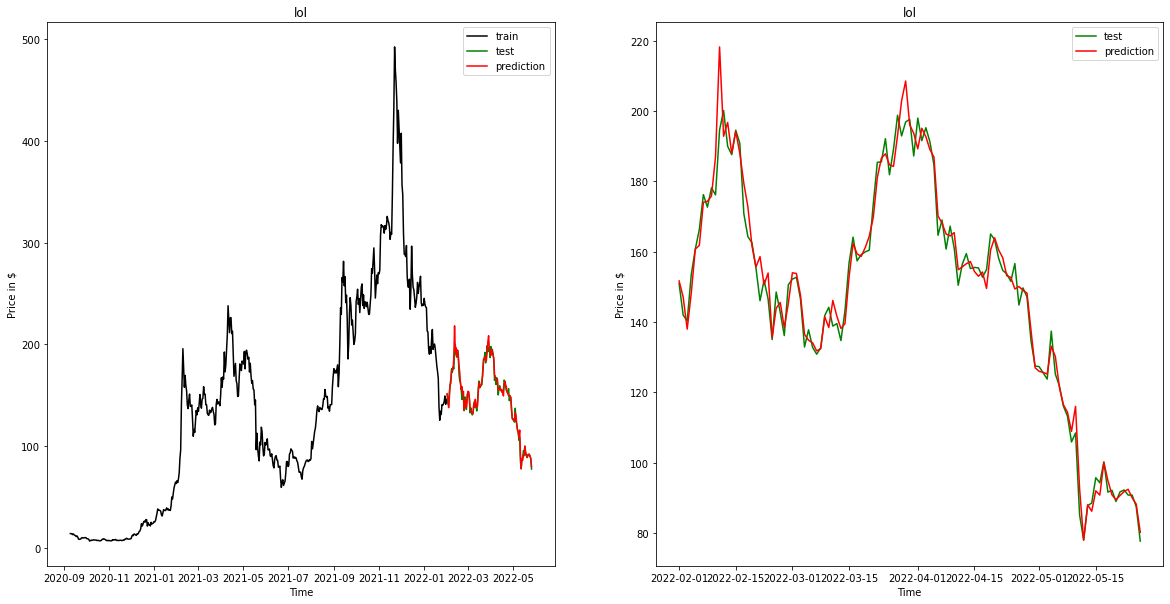

In [26]:
train_size = X_train.shape[0]
f,axs = plt.subplots(1,2,figsize=(20,10))

axs[0].set_title("lol")
axs[0].plot(df['date'][:train_size], df['close'][:train_size], color='black')
axs[0].plot(df['date'][train_size:], df['close'][train_size:], color='green')
axs[0].plot(df['date'][train_size:], linear_regression_validation_predict, color='red')
axs[0].legend(['train', 'test', 'prediction'])

axs[1].set_title("lol")
axs[1].plot(df['date'][train_size:], df['close'][train_size:], color='green')
axs[1].plot(df['date'][train_size:], linear_regression_validation_predict, color='red')
axs[1].legend(['test', 'prediction'])

for ax in axs.flat:
    ax.set(xlabel="Time", ylabel="Price in $")

## Tune

In [46]:
from sklearn.model_selection import GridSearchCV


lr_gs_model = LinearRegression()

# parameters that we will try to tune
params_lr_gs = {
    'n_jobs': range(1, 1000),
}

param_search = GridSearchCV( estimator=lr_gs_model, param_grid=params_lr_gs,
                verbose=1)
                
param_search.fit(X_train, y_train)

best_score = param_search.best_score_
best_params = param_search.best_params_

print(f'Best accuracy: {best_score} was obtained with parameters: {best_params}')

Fitting 5 folds for each of 999 candidates, totalling 4995 fits


KeyboardInterrupt: 

In [ ]:
lr_final_model = LinearRegression(**best_params)
lr_final_model.fit(X_train, y_train)

LinearRegression(n_jobs=1)

In [ ]:
lr_final_train_predict=lr_final_model.predict(X_train)
lr_final_validation_predict=lr_final_model.predict(X_test)

print("Train data prediction:", lr_final_train_predict.shape)
print("Validation data prediction:", lr_final_validation_predict.shape)
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_test, lr_final_validation_predict)))

Train data prediction: (12151,)
Validation data prediction: (2606,)
Mean Absolute Error - MAE : 0.5791713048464665


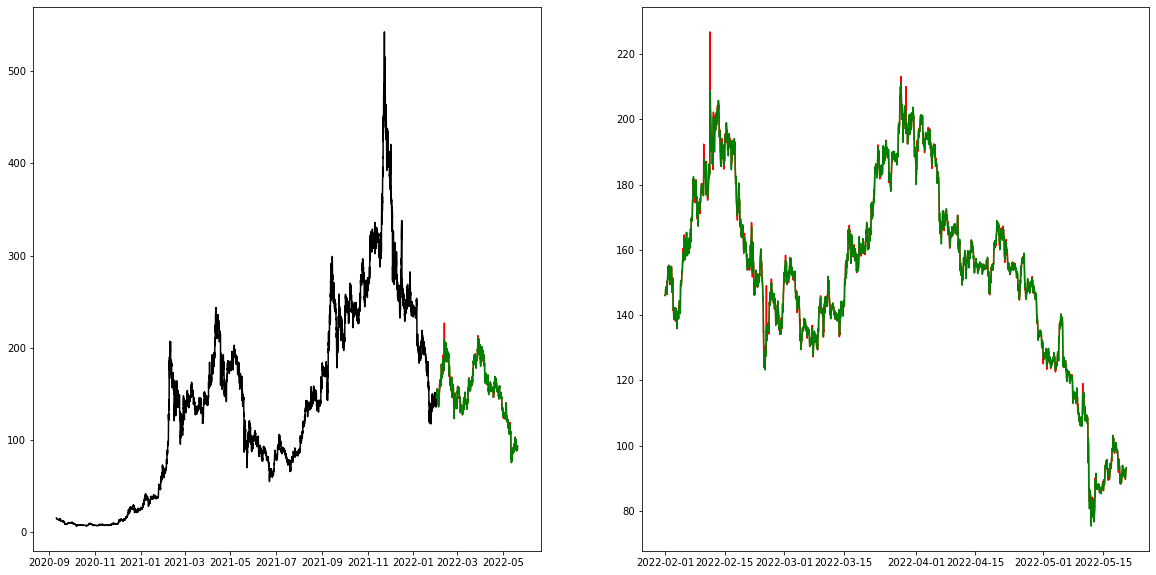

In [ ]:
train_size = X_train.shape[0]
f,axs = plt.subplots(1,2,figsize=(20,10))

axs[0].plot(df['date'][:train_size], df['close'][:train_size], color='black')
axs[0].plot(df['date'][train_size:], lr_final_validation_predict, color='red')
axs[0].plot(df['date'][train_size:], df['close'][train_size:], color='green')
axs[1].plot(df['date'][train_size:], lr_final_validation_predict, color='red')
axs[1].plot(df['date'][train_size:], df['close'][train_size:], color='green')

# LSTM

In [ ]:
date = '2022-02-01'
X_train, y_train, X_test, y_test = SplitData(df, date, lstm=1)

In [ ]:
y_train

array([[0.0163539 ],
       [0.01610578],
       [0.01633524],
       ...,
       [0.25456849],
       [0.25607961],
       [0.26031449]])

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((12151, 4, 1), (12151, 1), (2606, 4, 1), (2606, 1))

## Test

In [ ]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [ ]:
np.random.seed(42)
lstm_neurons = 100
epochs = 50
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [ ]:
lstm_model = build_lstm_model(X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss, optimizer=optimizer)
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [ ]:
hist = lstm_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/50
380/380 [==============================] - 7s 9ms/step - loss: 0.0032 - val_loss: 5.4118e-05
Epoch 2/50
380/380 [==============================] - 3s 7ms/step - loss: 2.9492e-04 - val_loss: 8.5620e-06
Epoch 3/50
380/380 [==============================] - 3s 7ms/step - loss: 2.6421e-04 - val_loss: 7.1701e-06
Epoch 4/50
380/380 [==============================] - 3s 7ms/step - loss: 2.2859e-04 - val_loss: 8.4471e-06
Epoch 5/50
380/380 [==============================] - 3s 7ms/step - loss: 2.2384e-04 - val_loss: 1.0149e-04
Epoch 6/50
380/380 [==============================] - 3s 7ms/step - loss: 2.0907e-04 - val_loss: 4.8604e-05
Epoch 7/50
380/380 [==============================] - 3s 7ms/step - loss: 1.8125e-04 - val_loss: 8.9475e-06
Epoch 8/50
380/380 [==============================] - 3s 7ms/step - loss: 1.6405e-04 - val_loss: 6.1518e-06
Epoch 9/50
380/380 [==============================] - 2s 6ms/step - loss: 1.6292e-04 - val_loss: 6.0709e-06
Epoch 10/50
380/380 [===========

In [ ]:
# make predictions
train_prediction = lstm_model.predict(X_train)
test_prediction = lstm_model.predict(X_test)

# invert predictions

# create empty table with 4 fields
train_prediction_dataset_like, test_prediction_dataset_like = np.zeros(shape=(len(train_prediction), X_train.shape[1])), np.zeros(shape=(len(test_prediction), X_test.shape[1]))
# put the predicted values in the right field
train_prediction_dataset_like[:,0], test_prediction_dataset_like[:,0] = train_prediction[:,0], test_prediction[:,0]
# inverse transform and then select the right field
train_prediction, test_prediction = X_scaler.inverse_transform(train_prediction_dataset_like)[:,0], X_scaler.inverse_transform(test_prediction_dataset_like)[:,0]
train_prediction, test_prediction = train_prediction.reshape(-1,1), test_prediction.reshape(-1,1)

y_train = y_scaler.inverse_transform(y_train)
y_test = y_scaler.inverse_transform(y_test)

In [ ]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(y_train,train_prediction)))
print("Train data MSE: ", mean_squared_error(y_train,train_prediction))
print("Train data MAE: ", mean_absolute_error(y_train,train_prediction))
print("Train data explained variance regression score:", explained_variance_score(y_train, train_prediction))
print("Train data R2 score:", r2_score(y_train, train_prediction))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(y_test,test_prediction)))
print("Test data MSE: ", mean_squared_error(y_test,test_prediction))
print("Test data MAE: ", mean_absolute_error(y_test,test_prediction))
print("Test data explained variance regression score:", explained_variance_score(y_test, test_prediction))
print("Test data R2 score:", r2_score(y_test, test_prediction))

Train data RMSE:  2.5438288017099495
Train data MSE:  6.471064972409079
Train data MAE:  2.0514573421962745
Train data explained variance regression score: 0.999426113584649
Train data R2 score: 0.999379679751081
-------------------------------------------------------------------------------------
Test data RMSE:  1.3883315145066029
Test data MSE:  1.9274643941721978
Test data MAE:  1.1005054170630875
Test data explained variance regression score: 0.9981439904242098
Test data R2 score: 0.9977130261759103


In [ ]:
train_size = X_train.shape[0]

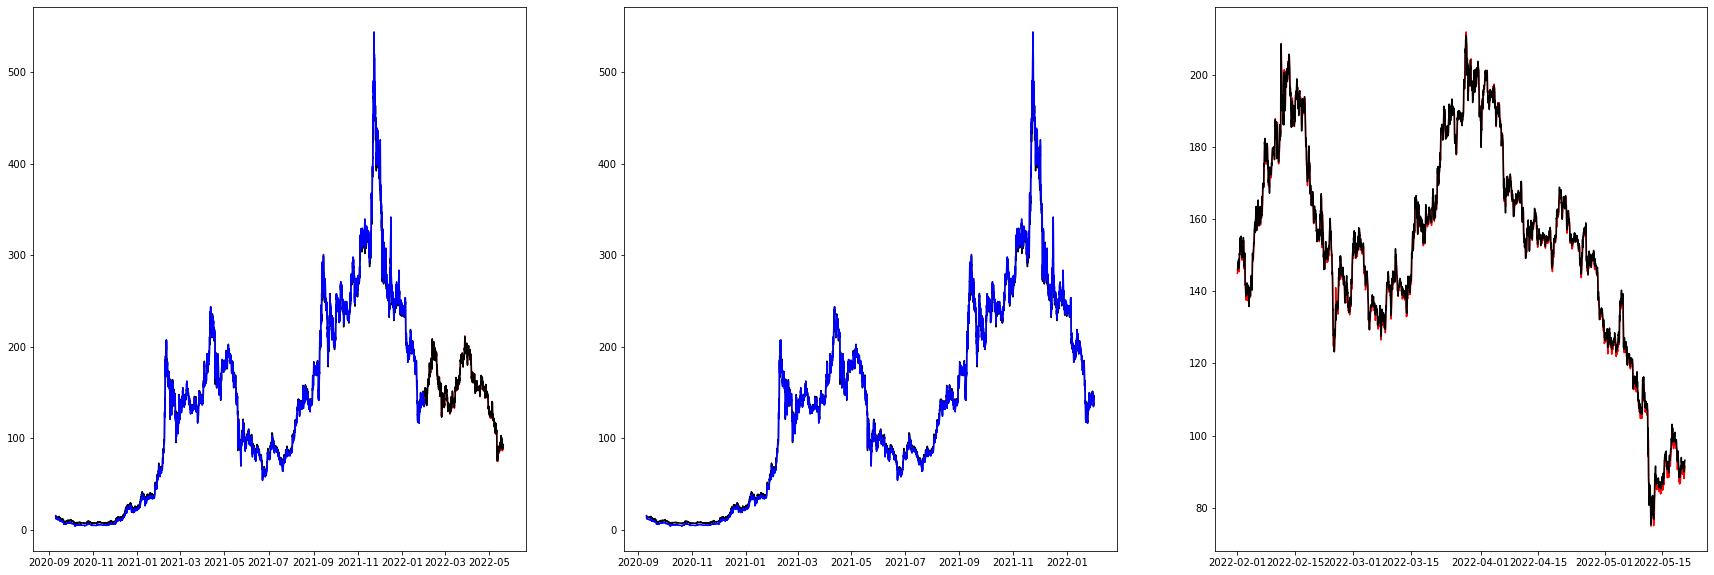

In [ ]:
f,axs = plt.subplots(1,3,figsize=(30,10))

axs[0].plot(df['date'][:train_size], df['close'][:train_size], color='black')
axs[0].plot(df['date'][:train_size], train_prediction, color='blue')
axs[0].plot(df['date'][train_size:], test_prediction, color='red')
axs[0].plot(df['date'][train_size:], df['close'][train_size:], color='black')
axs[1].plot(df['date'][:train_size], df['close'][:train_size], color='black')
axs[1].plot(df['date'][:train_size], train_prediction, color='blue')
axs[2].plot(df['date'][train_size:], test_prediction, color='red')
axs[2].plot(df['date'][train_size:], df['close'][train_size:], color='black')

plt.show()

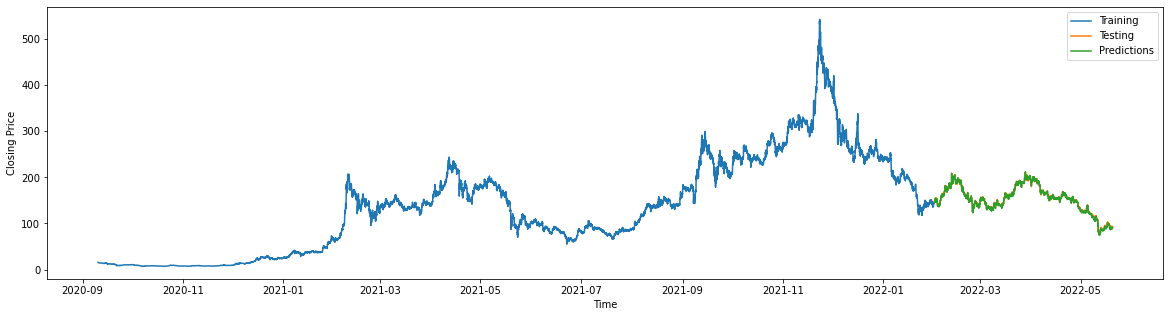

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(df['date'][df['date'] < date], y_train, label = 'Training')
plt.plot(df['date'][df['date'] >= date], y_test, label = 'Testing')
plt.plot(df['date'][df['date'] >= date], test_prediction, label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

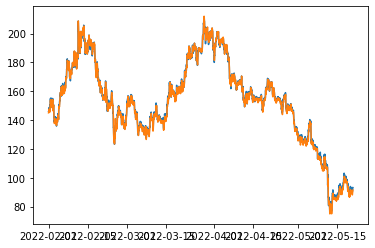

In [ ]:
plt.plot(df['date'][df['date'] >= date], df['close'][df['date'] >= date], label = 'Testing')
plt.plot(df['date'][df['date'] >= date], test_prediction, label = 'Predictions')

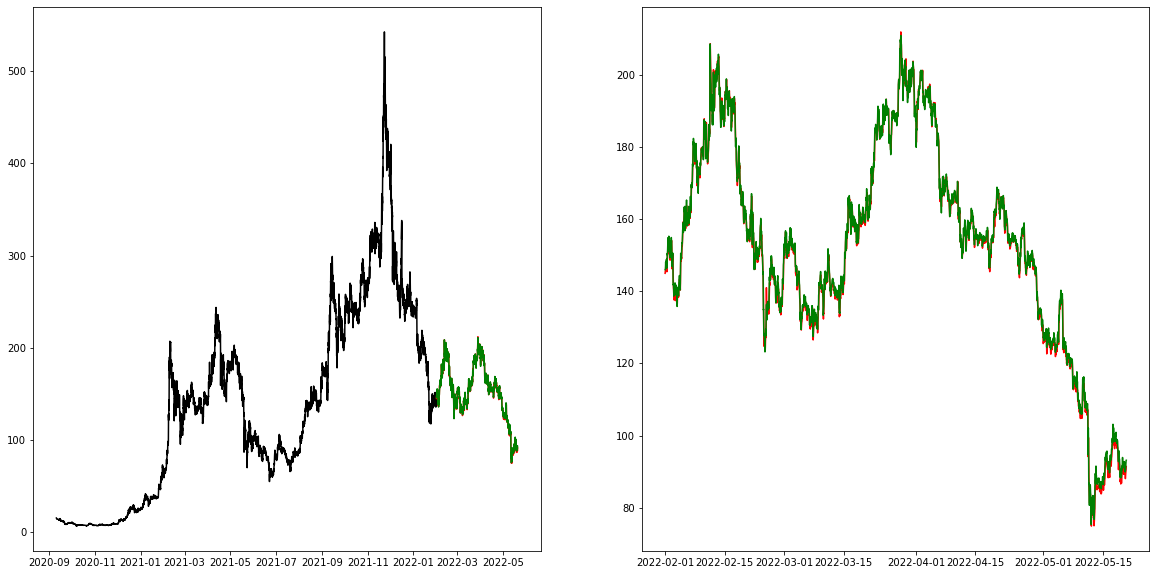

In [ ]:
f,axs = plt.subplots(1,2,figsize=(20,10))

axs[0].plot(df['date'][:train_size], df['close'][:train_size], color='black')
axs[0].plot(df['date'][train_size:], test_prediction, color='red')
axs[0].plot(df['date'][train_size:], df['close'][train_size:], color='green')
axs[1].plot(df['date'][train_size:], test_prediction, color='red')
axs[1].plot(df['date'][train_size:], df['close'][train_size:], color='green')

## Try Forecasting

In [ ]:
y_test.shape

(2482, 1)

In [ ]:
x_input = y_test[len(y_test)-4:].reshape(1, -1)
x_input.shape

array([[0.15267214, 0.15470936, 0.15280273, 0.15167592]])

In [ ]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()
temp_input

[[0.15267214165903797],
 [0.154709359692298],
 [0.15280273255860594],
 [0.1516759196537625]]

In [ ]:
lst_output = []
n_steps = 4
i = 0

while(i < 30):
    if(len(temp_input) > 100):
        x_input = np.array(temp_input[1:])
        print(f"{i} day input {x_input}")
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = lstm_model.predict(x_input, verbose=0)
        print(f"{i} day output {yhat}")
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = lstm_model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i = i + 1
print(lst_output)

[0.15444133]
[0.15444133]
[0.15444133]
[0.15444133]
[0.15444133]
[0.15444133]
[0.15444133]
[0.15444133]
[0.15444133]
[0.15444133]
[0.15444133]
[0.15444133]
[0.15444133]
[0.15444133]
[0.15444133]
[0.15444133]
[0.15444133]
[0.15444133]
[0.15444133]
[0.15444133]
[0.15444133]
[0.15444133]
[0.15444133]
[0.15444133]
[0.15444133]
[0.15444133]
[0.15444133]
[0.15444133]
[0.15444133]
[0.15444133]
[[0.15444132685661316], [0.15444132685661316], [0.15444132685661316], [0.15444132685661316], [0.15444132685661316], [0.15444132685661316], [0.15444132685661316], [0.15444132685661316], [0.15444132685661316], [0.15444132685661316], [0.15444132685661316], [0.15444132685661316], [0.15444132685661316], [0.15444132685661316], [0.15444132685661316], [0.15444132685661316], [0.15444132685661316], [0.15444132685661316], [0.15444132685661316], [0.15444132685661316], [0.15444132685661316], [0.15444132685661316], [0.15444132685661316], [0.15444132685661316], [0.15444132685661316], [0.15444132685661316], [0.15444132

In [ ]:
def forecast(model, batch_size, row):
	X = row[0:-1]
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

In [ ]:
yhat = forecast(lstm_model, 32, X_train)

ValueError: cannot reshape array of size 48600 into shape (1,1,12150)